In [335]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as opt
import csv

import matplotlib
matplotlib.rcParams['figure.dpi'] = 50

## Optimize time-optimal single pulse gates

In [336]:
#Set phase guess and pulse time for Pupillo gate
# pulse_time= 7.63*1 # in Omega*t dimension-less units
pulse_time= 15
dt = 4 #ns

Omega_Rabi=2*np.pi*1.1 #2.785 #MHz
rise_time_ns = 10 #ns
fall_time_ns = 10 #ns
PhaseGuess = phases_trace #input a phase profile guess 


delta1 = 0
delta2 = 0

epi1 = 0.05
epi2 = 0.01

max_slew_rate = 10 #MHz
Blockade = 130  #MHz
R_lifetime = 170 # microseconds

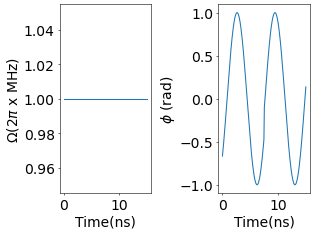

In [337]:
# duration_ns = 1/Omega_Rabi*1000*pulse_time
number_steps = int(duration_ns/dt+1)
number_steps = 200
# t = np.arange(0,duration_ns, dt)
t = np.linspace(0, pulse_time, number_steps)
Omega_t = np.zeros(number_steps)
phi_t = np.zeros(number_steps) 

rise_step = rise_time_ns//dt
fall_step = fall_time_ns//dt

# Omega_t[0:rise_step] = [Omega_Rabi*(1-np.cos(np.pi/rise_step*t))/2 for t in range(fall_step)]
# Omega_t[rise_step:-rise_step] = Omega_Rabi
# Omega_t[-rise_step:] = [Omega_Rabi*(1+np.cos(np.pi/rise_step*t))/2 for t in range(fall_step)]
Omega_t[:] = 1
fig, ax = plt.subplots(ncols=2)
ax[0].plot(t, Omega_t)
ax[0].set_xlabel('Time(ns)', fontsize=20)
ax[0].set_ylabel('$\Omega$($2\pi$ x MHz)', fontsize=20)
ax[0].tick_params(axis='both',labelsize=20)
A = 1
phi_t[:number_steps//2] = A*np.sin(1.043*2*2*np.pi/pulse_time*t[:number_steps//2]-0.73)
phi_t[number_steps//2:]=  A*np.sin(1.043*2*2*np.pi/pulse_time*t[:number_steps//2]-0.1)
# phi_t[80:130] +=  0.7*np.sin(0.543*2*2*np.pi/pulse_time*t[80:130]-1.5)+0.5
ax[1].plot(t, phi_t)
ax[1].set_xlabel('Time(ns)', fontsize=20)
ax[1].set_ylabel('$\phi$ (rad)',fontsize=20)
ax[1].tick_params(axis='both',labelsize=20)
fig.tight_layout()

In [338]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
delta_p = (delta1+delta2)/2
delta_m = (delta1-delta2)/2
epi_p = (epi1+epi2)/2
def ar_loss_function(phases, phi_rate_regulation_coe=1,amplitude_error=True, Omega=Omega):
    psi01 = np.array([1,0], dtype=np.complex64) #[01, 0r]
    psi10 = np.array([1,0], dtype=np.complex64) #[10, r0]
    psi11 = np.array([1,0,0], dtype=np.complex64) #[11, W+, W-]
    psi01_e = np.array([0,0], dtype=np.complex64) #[01, 0r]
    psi10_e = np.array([0,0], dtype=np.complex64) #[10, r0]
    psi11_e = np.array([0,0,0], dtype=np.complex64) #[11, W+, W-]
    dt_us = dt*1e-3
    for Omega, phi in zip(Omega_t, phases):
        H01 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
        H01e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
        H10 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta2]])/2
        H10e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
        H11 = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,delta_p/2,delta_m],[0,0,delta_p/2]])
        H11e = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,0,0],[0,0,0]])
        H01 += H01.conj().T 
        H10 += H10.conj().T 
        H11 += H11.conj().T
        H01e += H01e.conj().T 
        H10e += H10e.conj().T 
        H11e += H11e.conj().T
        psi01 = scipy.linalg.expm(-1j*H01*dt_us)@psi01
        psi10 = scipy.linalg.expm(-1j*H10*dt_us)@psi10
        psi11 = scipy.linalg.expm(-1j*H11*dt_us)@psi11

        psi01_e += (-1j*H01*dt_us)@psi01_e-(1j*H01e*dt_us)@psi01
        psi10_e += (-1j*H10*dt_us)@psi10_e-(1j*H10e*dt_us)@psi10
        psi11_e += (-1j*H11*dt_us)@psi11_e-(1j*H11e*dt_us)@psi11
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi10/=phase
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2  
        
    regulation = 0
    if phi_rate_regulation_coe is not None:
        for i in range(len(phases)-1):
            regulation = phi_rate_regulation_coe*(np.abs(phases[i+1]-phases[i])/dt_us/2/np.pi/max_slew_rate)**4
            
    return 1-F_bell+ regulation + np.sum(np.abs(psi01_e**2))+np.sum(np.abs(psi10_e**2)) + np.sum(np.abs(psi11_e**2))
    
def ar_modified_loss_function(phases, phi_rate_regulation_coe=None,amplitude_error=True, Omega_t=Omega_t):
    psi01 = np.array([1,0], dtype=np.complex64) #[01, 0r]
    psi10 = np.array([1,0], dtype=np.complex64) #[10, r0]
    psi11 = np.array([1,0,0], dtype=np.complex64) #[11, W+, W-]
    # psi01_e = np.array([0,0], dtype=np.complex64) #[01, 0r]
    # psi10_e = np.array([0,0], dtype=np.complex64) #[10, r0]
    # psi11_e = np.array([0,0,0], dtype=np.complex64) #[11, W+, W-]
    dt_us = dt
    for Omega, phi in zip(Omega_t, phases):
        H01 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
        # H01e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
        H10 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta2]])/2
        # H10e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
        H11 = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,delta_p/2,delta_m],[0,0,delta_p/2]])
        # H11e = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,0,0],[0,0,0]])
        H01 += H01.conj().T 
        H10 += H10.conj().T 
        H11 += H11.conj().T
        # H01e += H01e.conj().T 
        # H10e += H10e.conj().T 
        # H11e += H11e.conj().T
        psi01 = scipy.linalg.expm(-1j*H01*dt_us)@psi01
        psi10 = scipy.linalg.expm(-1j*H10*dt_us)@psi10
        psi11 = scipy.linalg.expm(-1j*H11*dt_us)@psi11

        # psi01_e += (-1j*H01*dt_us)@psi01_e-(1j*H01e*dt_us)@psi01
        # psi10_e += (-1j*H10*dt_us)@psi10_e-(1j*H10e*dt_us)@psi10
        # psi11_e += (-1j*H11*dt_us)@psi11_e-(1j*H11e*dt_us)@psi11
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi10/=phase
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    F_bell = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2  
    if amplitude_error:
        psi01 = np.array([1,0], dtype=np.complex64) #[01, 0r]
        psi10 = np.array([1,0], dtype=np.complex64) #[10, r0]
        psi11 = np.array([1,0,0], dtype=np.complex64) #[11, W+, W-]
        # psi01_e = np.array([0,0], dtype=np.complex64) #[01, 0r]
        # psi10_e = np.array([0,0], dtype=np.complex64) #[10, r0]
        # psi11_e = np.array([0,0,0], dtype=np.complex64) #[11, W+, W-]
        dt_us = dt
        for Omega, phi in zip(Omega_t, phases):
            Omega *= (1+epi1)
            H01 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
            # H01e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
            H10 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta2]])/2
            # H10e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
            H11 = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,delta_p/2,delta_m],[0,0,delta_p/2]])
            # H11e = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,0,0],[0,0,0]])
            H01 += H01.conj().T 
            H10 += H10.conj().T 
            H11 += H11.conj().T
            # H01e += H01e.conj().T 
            # H10e += H10e.conj().T 
            # H11e += H11e.conj().T
            psi01 = scipy.linalg.expm(-1j*H01*dt_us)@psi01
            psi10 = scipy.linalg.expm(-1j*H10*dt_us)@psi10
            psi11 = scipy.linalg.expm(-1j*H11*dt_us)@psi11
    
            # psi01_e += (-1j*H01*dt_us)@psi01_e-(1j*H01e*dt_us)@psi01
            # psi10_e += (-1j*H10*dt_us)@psi10_e-(1j*H10e*dt_us)@psi10
            # psi11_e += (-1j*H11*dt_us)@psi11_e-(1j*H11e*dt_us)@psi11
        # Apply single qubit gates
        phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
        psi01/=phase  # divide 1 atom state by phase shift
        psi10/=phase
        psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    
        F_bell_epi = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2    
    else:
        F_bell_epi = F_bell
   
    if amplitude_error:
        psi01 = np.array([1,0], dtype=np.complex64) #[01, 0r]
        psi10 = np.array([1,0], dtype=np.complex64) #[10, r0]
        psi11 = np.array([1,0,0], dtype=np.complex64) #[11, W+, W-]
        # psi01_e = np.array([0,0], dtype=np.complex64) #[01, 0r]
        # psi10_e = np.array([0,0], dtype=np.complex64) #[10, r0]
        # psi11_e = np.array([0,0,0], dtype=np.complex64) #[11, W+, W-]
        dt_us = dt
        for Omega, phi in zip(Omega_t, phases):
            Omega *= (1-epi1)
            H01 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
            # H01e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
            H10 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta2]])/2
            # H10e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
            H11 = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,delta_p/2,delta_m],[0,0,delta_p/2]])
            # H11e = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,0,0],[0,0,0]])
            H01 += H01.conj().T 
            H10 += H10.conj().T 
            H11 += H11.conj().T
            # H01e += H01e.conj().T 
            # H10e += H10e.conj().T 
            # H11e += H11e.conj().T
            psi01 = scipy.linalg.expm(-1j*H01*dt_us)@psi01
            psi10 = scipy.linalg.expm(-1j*H10*dt_us)@psi10
            psi11 = scipy.linalg.expm(-1j*H11*dt_us)@psi11
    
            # psi01_e += (-1j*H01*dt_us)@psi01_e-(1j*H01e*dt_us)@psi01
            # psi10_e += (-1j*H10*dt_us)@psi10_e-(1j*H10e*dt_us)@psi10
            # psi11_e += (-1j*H11*dt_us)@psi11_e-(1j*H11e*dt_us)@psi11
        # Apply single qubit gates
        phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
        psi01/=phase  # divide 1 atom state by phase shift
        psi10/=phase
        psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    
        F_bell_mepi = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2    
    else:
        F_bell_mepi = F_bell     
    regulation = 0
    if phi_rate_regulation_coe is not None:
        for i in range(len(phases)-1):
            regulation = phi_rate_regulation_coe*(np.abs(phases[i+1]-phases[i])/dt_us/2/np.pi/max_slew_rate)**4
            
    return 1-F_bell+ regulation + np.max([0,(F_bell-F_bell_epi)])+ np.max([0,(F_bell-F_bell_mepi)])

In [339]:
#optimize the fidelity over the input phases using built-in scipy optimizer
phases_out=opt.minimize(fun=ar_modified_loss_function,x0=phi_t)

In [340]:
1-ar_modified_loss_function(phases_out['x'], phi_rate_regulation_coe=None, amplitude_error=False )

np.float64(0.7975548336386153)

Text(0.5, 0, 'Time $t\\Omega_0$')

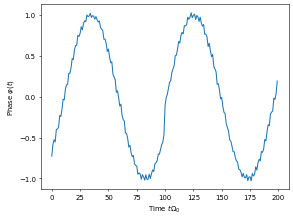

In [341]:
times_list = []
interpolation = []
phases = []
# for i in range(resolution):
    # times_list.append(np.linspace(0, 7.63,resolution + 1)[i])
    # phases.append(phases_out['x'][i])
# fig, ax = plt.plot(figsize = (8,8))
phi_t = phases_out['x']
plt.plot(phi_t)
# plt.title("$\\Omega$T= 7.63")
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")


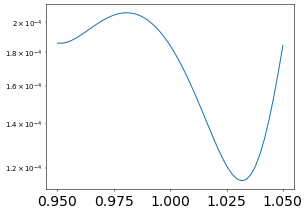

In [232]:
#check the optimized fidelity
episilon = np.linspace(0.95,1.05,50)
infidelity = []
for epi in episilon:
    infidelity.append(ar_modified_loss_function(phases_out['x'], phi_rate_regulation_coe=None, amplitude_error=False, Omega_t=epi*Omega_t))
plt.plot(episilon, infidelity)
plt.yscale('log')
plt.tick_params(axis='both', labelsize=20)

In [138]:
F_bell = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2  
# regulation
np.abs(psi01_e[0]**2) + np.abs(psi10_e[0]**2) + np.abs(psi11_e[0]**2)

np.float32(177.38702)

<h2> Debugging </h2>

In [51]:
H01 = np.zeros((4,4),dtype=np.complex64)
H01_0 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
H01_1 = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
H01_0 += H01_0.conj().T 
H01_1 += H01_1.conj().T 
H01[0:2,0:2] = H01_0
H01[2:4,2:4] = H01_0
H01[2:4,0:2] = H01_1

[[ 0.       31.415926  0.        0.      ]
 [31.415926  0.        0.        0.      ]
 [ 0.       31.415926  0.       31.415926]
 [31.415926  0.       31.415926  0.      ]]


In [62]:
def evolve_H10(t,y):
    psi = y[:4] + 1j* y[4:]
    evo = -1j*H01@psi
    return np.concatenate((evo.real, evo.imag))
y0 = np.zeros(8, dtype=np.complex64)
y0[0] = 1 
from scipy.integrate import solve_ivp
# print(t)
sol = solve_ivp(evolve_H10, (0,t[-1]), y0, t_eval=t, method='RK45',rtol=1e-11, atol=1e-12)


In [64]:
yf = sol.y
psi = yf[:4] +1j*yf[4:]
psi

array([[ 1.00000000e+00+0.00000000e+00j,  1.00000000e+00+4.70857699e-17j,
         1.00000000e+00+4.21113895e-16j,  1.00000000e+00+1.33998047e-15j,
         1.00000000e+00+1.73938769e-15j,  1.00000000e+00+1.07641490e-15j,
         1.00000000e+00+1.13223116e-15j,  1.00000000e+00+1.29236085e-15j,
         1.00000000e+00+1.40867990e-15j,  1.00000000e+00+9.07874836e-16j,
         9.99999999e-01+9.99083696e-16j,  9.99999999e-01+2.03498030e-15j,
         9.99999999e-01+2.15213497e-15j,  9.99999999e-01+2.51389405e-15j,
         9.99999999e-01+2.07387964e-15j,  9.99999999e-01+2.68513391e-15j,
         9.99999999e-01+2.21370615e-15j,  9.99999999e-01+2.81148489e-15j,
         9.99999999e-01+2.37534259e-15j,  9.99999999e-01+2.54607914e-15j,
         9.99999999e-01+1.03842942e-15j,  9.99999999e-01+9.81527626e-16j,
         9.99999999e-01+1.56257094e-15j,  9.99999999e-01+1.64967631e-15j,
         9.99999999e-01+2.11753489e-15j,  9.99999999e-01+2.93321418e-15j,
         9.99999999e-01+2.92602882e-15

In [67]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt_amp(phases):
    
    
    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = None#Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    dOmega=0.01
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 
    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = (OmegaNorm+dOmega)*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bellP = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
     
    return (1-F_bell)+abs(psi11[1])*(1/0.01)

In [68]:
phases_out=opt.minimize(fun=pulse_gate_infidelity_opt_amp,x0=PhaseGuess)

In [69]:
1-pulse_gate_infidelity_opt(phases_out['x'])

0.973927516044707

Text(0.5, 0, 'Time $t\\Omega_0$')

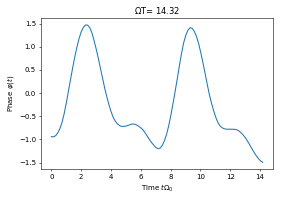

In [65]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(PhaseGuess[i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

Text(0.5, 0, 'Time $t\\Omega_0$')

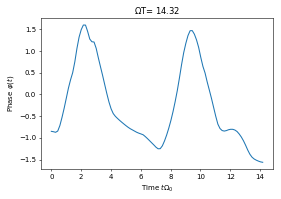

In [66]:
times_list = []
interpolation = []
phases = []
for i in range(resolution):
    times_list.append(np.linspace(0, pulse_time,resolution + 1)[i])
    phases.append(phases_out['x'][i])
# fig, ax = plt.plot(figsize = (8,8))

plt.plot(times_list, phases)
plt.title("$\\Omega$T= {}".format(pulse_time))
plt.ylabel("Phase $\\varphi(t)$")
plt.xlabel("Time $t\Omega_0$")

In [ ]:
# Calculates both Bell state fidelity for input phases and return the output for optimization
def pulse_gate_infidelity_opt_amp(phases):
    
    
    times=np.linspace(0,pulse_time*1,resolution+1) # Time in dimensionless units omega_rabi*t
    OmegaNorm=1 # normalize to 1 to keep timings consistant
    DecayRate=(1/R_lifetime)/(Omega_Rabi) # Decay rate normalized with Rabi frequency 
    B = None#Blockade/Omega_Rabi # normalize the blockade with the Rabi frequency
    dOmega=0.01
    
    psi01 = np.array([1,0], complex)  # single atom state ground and Rydberg
    psi11 = np.array([1,0,0], complex) # two atom state ground-ground, ground-Rydberg, Rydberg-Rydberg 
    if B is None:  #None is infinite blockade
        psi11 = np.array([1,0], complex)  # dont need the 3rd element if blockade is infinite
        
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = OmegaNorm*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bell = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 
    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
    for i in range(resolution):  #loop over small time increments and apply small unitary rotations at each step
        dt = times[i+1]-times[i]  #time increment difference
        Omega = (OmegaNorm+dOmega)*np.exp(1j*phases[i])  #set up the complex Rabi frequency
        H01 = 0.5*np.array([[0, Omega], [np.conj(Omega), 0]]) #Hamiltonian for one atom 
        if B is None:
            H11 = np.sqrt(2)*H01   # Hamiltonian for two atoms when the blockade is infinite
        else:
            H11 = np.sqrt(2)*0.5*np.array([[0, Omega, 0], [np.conj(Omega), 0, Omega], [0, np.conj(Omega), 0]])   # Hamiltonian for two atoms
            H11[2,2] = B-1j*DecayRate # add in finite blockade and decay for the double exciation term
        H01[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the one atom Hamiltonian
        H11[1,1] = -1j*DecayRate/2  # add in decay for the single excitation term for the two atom Hamiltonian
        psi01 = scipy.linalg.expm(-1j*H01*dt)@psi01  #evolve input 1 atom state in time
        psi11 = scipy.linalg.expm(-1j*H11*dt)@psi11  #evolve 2 atom state
    
    # Apply single qubit gates
    phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
    psi01/=phase  # divide 1 atom state by phase shift
    psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom
    F_bellP = 1/16*np.abs(1+2*psi01[0]-psi11[0])**2 

    # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
    # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
    # For perfect fidelity, there will be a pi phase shift between the two t
    
     
    return (1-F_bell)+abs(psi11[1])*(1/0.01)

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
# blockade_list_MHz = np.linspace(2,3.6,50)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)

In [ ]:
fidelity_vs_blockade = []
blockade_list = np.linspace(2*2*np.pi,3.6*2*np.pi,50)
blockade_list_MHz = np.linspace(5,7,50)
for blockade in blockade_list:
    fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
    fidelity_vs_blockade.append(fidelity)

In [ ]:
# fidelity_vs_blockade = []
# blockade_list = np.linspace(1.78*2*np.pi,3.2*2*np.pi,13)
# blockade_list_MHz = np.linspace(1.8,3,13)
# for blockade in blockade_list:
#     fidelity =1-pulse_gate_infidelity_blockade_sensitivity(phases = phases_out['x'], blockade=blockade)
#     fidelity_vs_blockade.append(fidelity)
    

In [ ]:


matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(15, 10))
plt.ylabel("Fidelity")
plt.xlabel("Blockade (MHz)/(2pi)")
display(plt.plot(blockade_list_MHz, fidelity_vs_blockade))

In [ ]:
1-pulse_gate_infidelity_blockade_sensitivity(phases=phases_out['x'],blockade= 2*np.pi*2.3)

In [81]:
phases_trace=[-0.939307, -0.944878, -0.919563, -0.860977, -0.766731, -0.63444, -0.445679, -0.213956, 0.0397753, 0.298914, 0.5475, 0.783185, 0.997218, 1.18084, 1.32405, 1.42267, 1.47112, 1.46865, 1.4133, 1.30311, 1.13611, 0.955495, 0.753617, 0.539173, 0.320853, 0.107349, -0.0808295, -0.252603, -0.40345, -0.526104, -0.607842, -0.665501, -0.702364, -0.718366, -0.719367, -0.710306, -0.695521, -0.679351, -0.666134, -0.669722, -0.690451, -0.718328, -0.753516, -0.796175, -0.863264, -0.934328, -1.00495, -1.0707, -1.12717, -1.17571, -1.19996, -1.18686, -1.12475, -1.02399, -0.885988, -0.698973, -0.473489, -0.22414, 0.0408116, 0.313102, 0.597742, 0.862266, 1.09139, 1.25147, 1.35933, 1.41343, 1.39837, 1.33256, 1.22229, 1.06936, 0.875445, 0.658711, 0.429326, 0.197459, -0.0267189, -0.212619, -0.375743, -0.517777, -0.635883, -0.706367, -0.748029, -0.770306, -0.778467, -0.778698, -0.779417, -0.779716, -0.783216, -0.793537, -0.822326, -0.862298, -0.911098, -0.971297, -1.04547, -1.12437, -1.20437, -1.28185, -1.35317, -1.41472, -1.46285, -1.49395]

In [ ]:
pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
len(pulse_times_in_ns)

pulse_time_in_ns=4*int(1e3*pulse_time/Omega_Rabi/4)
pulse_times_in_ns = range(0,pulse_time_in_ns,4)
phases_in_radians=np.interp(np.linspace(0,pulse_time,len(pulse_times_in_ns)),np.linspace(0,pulse_time,resolution),phases_out['x'])

row_list=  [('time_in_ns', 'phase_in_radians')] + list(list(zip(pulse_times_in_ns,phases_in_radians)))

with open('gate_phase_file.csv','w',newline='') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

In [65]:
phi_rate_regulation_coe = None
psi01 = np.array([1,0], dtype=np.complex64) #[01, 0r]
psi10 = np.array([1,0], dtype=np.complex64) #[10, r0]
psi11 = np.array([1,0,0], dtype=np.complex64) #[11, W+, W-]
psi01_e = np.array([0,0], dtype=np.complex64) #[01, 0r]
psi10_e = np.array([0,0], dtype=np.complex64) #[10, r0]
psi11_e = np.array([0,0,0], dtype=np.complex64) #[11, W+, W-]
dt_us = dt*1e-3
for Omega, phi in zip(Omega_t, phi_t):
    H01 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta1]])/2
    # H01e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
    H10 = np.array([[0,Omega*np.exp(1j*phi)],[0,delta2]])/2
    # H10e = np.array([[0,Omega*np.exp(1j*phi)],[0,0]])/2
    H11 = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,delta_p/2,delta_m],[0,0,delta_p/2]])
    # H11e = np.array([[0,1/np.sqrt(2)*Omega*np.exp(1j*phi),0],[0,0,0],[0,0,0]])
    H01 += H01.conj().T 
    H10 += H10.conj().T 
    H11 += H11.conj().T
    # H01e += H01e.conj().T 
    # H10e += H10e.conj().T 
    # H11e += H11e.conj().T
    # psi01_e += (-1j*H01*dt_us)@psi01_e-(1j*H01e*dt_us)@psi01
    # psi10_e += (-1j*H10*dt_us)@psi10_e-(1j*H10e*dt_us)@psi10
    # psi11_e += (-1j*H11*dt_us)@psi11_e-(1j*H11e*dt_us)@psi11
        
    psi01 += (-1j*H01*dt_us)@psi01
    psi10 += (-1j*H10*dt_us)@psi10
    psi11 += (-1j*H11*dt_us)@psi11
# Apply single qubit gates
# phase = psi01[0]/np.abs(psi01[0]) # Calculate the phase shift induced on the ground state for 1 atom
# psi01/=phase  # divide 1 atom state by phase shift
# psi10/=phase
# psi11/=phase**2 #divide 2 atom state by 1 atom phase shift on each atom

# # Bell state fidelity based on ground state populations for the 1 atom and 2 atom case. 
# # The relative phase shifts between the two psi01[0] and psi11[0] are also accounted for in this calculation
# # For perfect fidelity, there will be a pi phase shift between the two t

F_bell = 1/16*np.abs(1+psi10[0]+psi01[0]-psi11[0])**2  
# regulation = 0
# if phi_rate_regulation_coe is not None:
#     for i in range(len(phases)-1):
#         regulation = phi_rate_regulation_coe*(np.abs(phases[i+1]-phases[i])/dt_us/2/np.pi/max_slew_rate)**4